# Data Preparation
Let's load this data into Python. I will load the dataset with Pandas onto Dataframes ratings. Before that, I'll also pass in column names for each CSV and read them using pandas (the column names are available in the Readme file)

In [17]:
import os

In [18]:
os.chdir("E:\Insofe\PH.D\PHD_ML")

In [19]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Reading ratings file
# Ignore the timestamp column
ratings = pd.read_csv("user_hotel_rating-1555730075105.csv")

In [20]:
# Removing user_ Sign from userid column
ratings['Hotelid'] = ratings['Hotelid'].str.replace('hotel_', '').astype('int64')

In [21]:
# Removing user_ Sign from userid column
ratings['userid'] = ratings['userid'].str.replace('user_', '').astype('int64')

# Ratings Dataset¶


In [22]:
# Check the top 5 rows
print(ratings.head())

   userid  Hotelid  OverallRating
0   78131      558              3
1   78131      603              2
2   78131      610              3
3   78131      574              3
4   78131      570              3


In [23]:
# Check the file info
print(ratings.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 271935 entries, 0 to 271934
Data columns (total 3 columns):
userid           271935 non-null int64
Hotelid          271935 non-null int64
OverallRating    271935 non-null int64
dtypes: int64(3)
memory usage: 6.2 MB
None


# Data Exploration

# Ratings
Next I want to examine the rating further. Let's take a look at its summary statistics and distribution.

In [24]:
# Get summary statistics of rating
ratings['OverallRating'].describe()

count    271935.000000
mean          3.257113
std           1.064767
min           1.000000
25%           3.000000
50%           3.000000
75%           4.000000
max           5.000000
Name: OverallRating, dtype: float64

C:\Users\prash\Anaconda3\lib\site-packages\matplotlib\axes\_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


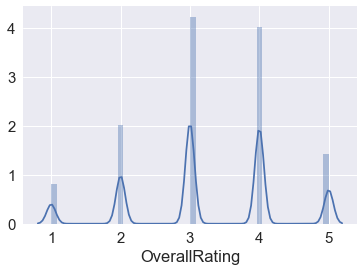

In [25]:
# Import seaborn library
import seaborn as sns
sns.set_style('whitegrid')
sns.set(font_scale=1.5)
%matplotlib inline

# Display distribution of rating
sns.distplot(ratings['OverallRating'].fillna(ratings['OverallRating'].median()))

It appears that users are quite generous in their ratings. The mean rating is 3.27 on a scale of 5. Half the hotels have a rating of 3 and 4. I personally think that a 5-level rating skill wasn’t a good indicator as people could have different rating styles (i.e. person A could always use 4 for an average hotel, whereas person B only gives 4 out for their favorites). Each user rated at least 20 hotels, so I doubt the distribution could be caused just by chance variance in the quality of hotel

# Types of Recommendation Engines
1. Content-Based
The Content-Based Recommender relies on the similarity of the items being recommended. The basic idea is that if you like an item, then you will also like a “similar” item. It generally works well when it's easy to determine the context/properties of each item.

    A content based recommender works with data that the user provides, either explicitly hotel ratings for the dataset. Based on that data, a user profile is generated, which is then used to make suggestions to the user. As the user provides more inputs or takes actions on the recommendations, the engine becomes more and more accurate.

2. Collaborative Filtering
The Collaborative Filtering Recommender is entirely based on the past behavior and not on the context. More specifically, it is based on the similarity in preferences, tastes and choices of two users. It analyses how similar the tastes of one user is to another and makes recommendations on the basis of that.

For instance, if user A likes Hotels 1, 2, 3 and user B likes Hotels 2,3,4, then they have similar interests and A should like hotel 4 and B should like hotel 1. This makes it one of the most commonly used algorithm as it is not dependent on any additional information.

In general, collaborative filtering is the workhorse of recommender engines. The algorithm has a very interesting property of being able to do feature learning on its own, which means that it can start to learn for itself what features to use. It can be divided into Memory-Based Collaborative Filtering and Model-Based Collaborative filtering. In this post, I'll only focus on the Memory-Based Collaborative Filtering technique.

# Collaborative Filtering Recommendation Model
The content based engine suffers from some severe limitations. It is only capable of suggesting hotels which are close to a certain hotel. That is, it is not capable of capturing tastes and providing recommendations across genres.

Also, the engine that we built is not really personal in that it doesn't capture the personal tastes and biases of a user. Anyone querying our engine for recommendations based on a hotel will receive the same recommendations for that hotel, regardless of who she/he is.

Therefore, in this section, I will use Memory-Based Collaborative Filtering to make recommendations to hotel users. The technique is based on the idea that users similar to a me can be used to predict how much I will like a particular product or service those users have used/experienced but I have not.

# There are 2 main types of memory-based collaborative filtering algorithms:

User-User Collaborative Filtering: Here we find look alike users based on similarity and recommend hotels which first user’s look-alike has chosen in past. This algorithm is very effective but takes a lot of time and resources. It requires to compute every user pair information which takes time. Therefore, for big base platforms, this algorithm is hard to implement without a very strong parallelizable system.

Item-Item Collaborative Filtering: It is quite similar to previous algorithm, but instead of finding user's look-alike, we try finding hotel's look-alike. Once we have hotel's look-alike matrix, we can easily recommend alike hotels to user who have rated any hotel from the dataset. This algorithm is far less resource consuming than user-user collaborative filtering. Hence, for a new user, the algorithm takes far lesser time than user-user collaborate as we don’t need all similarity scores between users. And with fixed number of hotels, hotel-hotel look alike matrix is fixed over time.

In [26]:
# Fill NaN values in userid and Hotelid column with 0
ratings['userid'] = ratings['userid'].fillna(0)
ratings['Hotelid'] = ratings['Hotelid'].fillna(0)

# Replace NaN values in overallrating column with average of all values
ratings['OverallRating'] = ratings['OverallRating'].fillna(ratings['OverallRating'].mean())

Due to the limited computing power in my laptop, I will build the recommender system using only a subset of the ratings. In particular, I will take a random sample of 20,000 ratings (2%) from the 1M ratings.

In [27]:
# Randomly sample 1% of the ratings dataset
small_data = ratings.sample(frac=0.02)
# Check the sample info
print(small_data.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5439 entries, 236505 to 204144
Data columns (total 3 columns):
userid           5439 non-null int64
Hotelid          5439 non-null int64
OverallRating    5439 non-null int64
dtypes: int64(3)
memory usage: 170.0 KB
None


Now I use the scikit-learn library to split the dataset into testing and training. Cross_validation.train_test_split shuffles and splits the data into two datasets according to the percentage of test examples, which in this case is 0.2.

In [28]:

from sklearn import model_selection as cv
train_data, test_data = cv.train_test_split(small_data, test_size=0.2)


Now I need to create a user-item matrix. Since I have splitted the data into testing and training, I need to create two matrices. The training matrix contains 80% of the ratings and the testing matrix contains 20% of the ratings.

In [36]:
# Create two user-item matrices, one for training and another for testing
train_data_matrix = train_data.as_matrix(columns = ['userid', 'Hotelid', 'OverallRating'])
test_data_matrix = test_data.as_matrix(columns = ['userid', 'Hotelid', 'OverallRating'])
# Check their shape
print(train_data_matrix.shape)
print(test_data_matrix.shape)


C:\Users\prash\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  
C:\Users\prash\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  This is separate from the ipykernel package so we can avoid doing imports until


AttributeError: 'numpy.ndarray' object has no attribute 'drop'


Now I use the pairwise_distances function from sklearn to calculate the Pearson Correlation Coefficient. This method provides a safe way to take a distance matrix as input, while preserving compatibility with many other algorithms that take a vector array.

In [30]:
from sklearn.metrics.pairwise import pairwise_distances

# User Similarity Matrix
user_correlation = 1 - pairwise_distances(train_data, metric='correlation')
user_correlation[np.isnan(user_correlation)] = 0
print(user_correlation[:4, :4])

[[1.         0.99999956 0.99999959 0.99991394]
 [0.99999956 1.         0.99999829 0.99992582]
 [0.99999959 0.99999829 1.         0.99990158]
 [0.99991394 0.99992582 0.99990158 1.        ]]


In [31]:
# Item Similarity Matrix
item_correlation = 1 - pairwise_distances(train_data_matrix.T, metric='correlation')
item_correlation[np.isnan(item_correlation)] = 0
print(item_correlation[:4, :4])

[[ 1.         -0.01447986  0.0280043 ]
 [-0.01447986  1.          0.00291333]
 [ 0.0280043   0.00291333  1.        ]]


With the similarity matrix in hand, I can now predict the ratings that were not included with the data. Using these predictions, I can then compare them with the test data to attempt to validate the quality of our recommender model.

For the user-user CF case, I will look at the similarity between 2 users (A and B, for example) as weights that are multiplied by the ratings of a similar user B (corrected for the average rating of that user). I also need to normalize it so that the ratings stay between 1 and 5 and, as a final step, sum the average ratings for the user that I am trying to predict. The idea here is that some users may tend always to give high or low ratings to all movies. The relative difference in the ratings that these users give is more important than the absolute values.

In [32]:

# Function to predict ratings
def predict(ratings, similarity, type='user'):
    if type == 'user':
        mean_user_rating = ratings.mean(axis=1)
        # Use np.newaxis so that mean_user_rating has same format as ratings
        ratings_diff = (ratings - mean_user_rating[:, np.newaxis])
        pred = mean_user_rating[:, np.newaxis] + similarity.dot(ratings_diff) / np.array([np.abs(similarity).sum(axis=1)]).T
    elif type == 'item':
        pred = ratings.dot(similarity) / np.array([np.abs(similarity).sum(axis=1)])
    return pred

Evaluation
There are many evaluation metrics but one of the most popular metric used to evaluate accuracy of predicted ratings is Root Mean Squared Error (RMSE). I will use the mean_square_error (MSE) function from sklearn, where the RMSE is just the square root of MSE.

$$\mathit{RMSE} =\sqrt{\frac{1}{N} \sum (x_i -\hat{x_i})^2}$$
I'll use the scikit-learn's mean squared error function as my validation metric. Comparing user- and item-based collaborative filtering, it looks like user-based collaborative filtering gives a better result.

In [33]:
from sklearn.metrics import mean_squared_error
from math import sqrt

# Function to calculate RMSE
def rmse(pred, actual):
    # Ignore nonzero terms.
    pred = pred[actual.nonzero()].flatten()
    actual = actual[actual.nonzero()].flatten()
    print(pred)
    print(actual)
    return sqrt(mean_squared_error(pred, actual))

In [34]:
# Predict ratings on the training data with both similarity score
user_prediction = predict(train_data_matrix, user_correlation, type='user')
item_prediction = predict(train_data_matrix, item_correlation, type='item')

# RMSE on the test data
print('User-based CF RMSE: ' + str(rmse(user_prediction, test_data_matrix)))
print('Item-based CF RMSE: ' + str(rmse(item_prediction, test_data_matrix)))

[56064.62560386  4683.91038959  4116.46400656 ... 50632.45677839
  -748.00513037 -1315.45164802]
[65137   522     3 ... 63543   516     3]
User-based CF RMSE: 10732.372245167437
[61721.49929432  -413.59082433  1752.41266368 ... 46005.87644099
   -94.92730742  1306.68073499]
[65137   522     3 ... 63543   516     3]
Item-based CF RMSE: 12915.176540332812


In [37]:
# RMSE on the train data
print('User-based CF RMSE: ' + str(rmse(user_prediction, train_data_matrix)))
print('Item-based CF RMSE: ' + str(rmse(item_prediction, train_data_matrix)))

User-based CF RMSE: 7573.526805686977
Item-based CF RMSE: 498.1136967675142



RMSE of training of model is a metric which measure how much the signal and the noise is explained by the model. I noticed that my RMSE is quite big. I suppose I might have overfitted the training data.

Overall, Memory-based Collaborative Filtering is easy to implement and produce reasonable prediction quality. However, there are some drawback of this approach:

It doesn't address the well-known cold-start problem, that is when new user or new item enters the system.
It can't deal with sparse data, meaning it's hard to find users that have rated the same items.
It suffers when new users or items that don't have any ratings enter the system.
It tends to recommend popular items.